# Quick start for binary classification

Quick start for binary classification

In [1]:
# bash generate_data_binary.sh

In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pymc3 # this will be removed
import pydot # optional

Using TensorFlow backend.


In [3]:
%run -i ImaGene.py

First iteration.

Read simulations and store them into object.

In [4]:
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations1.Epoch3', nr_samples=128, model_name='Marth-3epoch-CEU')

In [5]:
mygene = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

Have a look at the data and the allele frequency for the selected allele.

In [6]:
mygene.summary()

An object of 10000 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 94, max 443, mean 258.188000, std 55.710700


0

Text(0, 0.5, 'Allele frequency')

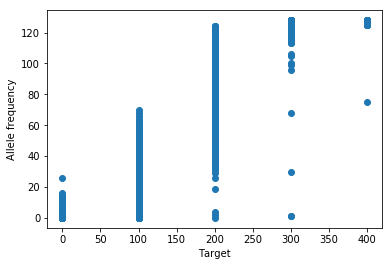

In [7]:
freqs = calculate_allele_frequency(mygene, 0.5)
plt.scatter(mygene.targets, freqs, marker='o')
plt.xlabel('Target')
plt.ylabel('Allele frequency')

Manipulate object to: major/minor polarisation, sort rows/cols, resize, convert to float.

In [8]:
mygene.majorminor()
mygene.filter_freq(0.01)
mygene.sort('rows_freq')
mygene.sort('cols_freq')
mygene.resize((128, 128))
mygene.convert(verbose=True)

Converting to numpy array.
Converting to float32.
Converting to [0,1].
Flipping values.
A numpy array with dimensions (10000, 128, 128, 1) and 10000 targets and 5 classes.


0

Plot one image per class as an illustration and check the new dimensions.

0


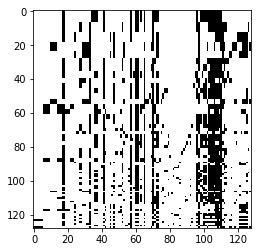

100


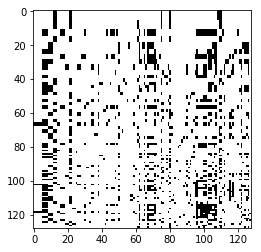

200


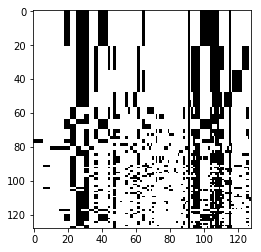

300


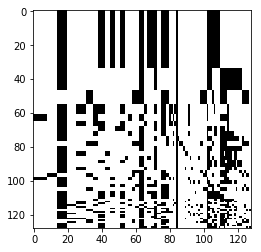

400


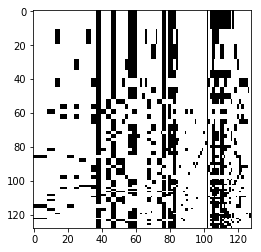

An object of 10000 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 128, max 128, mean 128.000000, std 0.000000


0

In [9]:
for sel in mygene.classes:
    print(sel)
    mygene.plot(np.where(mygene.targets == sel)[0][0])
mygene.summary()

Select only images corresponding to specified classes (e.g. 0 and 300) and check new dimensions.

In [10]:
mygene.classes = np.array([0,300])
classes_idx = get_index_classes(mygene.targets, mygene.classes)
len(classes_idx)

4000

In [11]:
mygene.subset(classes_idx)
mygene.summary()

An object of 4000 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 128, max 128, mean 128.000000, std 0.000000


0

Randomly shuffle images.

In [12]:
rnd_idx = get_index_random(mygene)
mygene.subset(rnd_idx)

0

Convert targets to the appropriate format for keras (vectorise them).

In [13]:
mygene.targets = to_binary(mygene.targets)

The data is ready to be used for the classification.
You can save it.

In [14]:
mygene.save(file='mygene')

0

In [ ]:
# to load:
mygene = load_imagene(file='mygene')

Build the keras model.

In [15]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=mygene.data.shape[1:4]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=64, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Summary of the model.

In [17]:
model.summary()
plot_model(model, 'net.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

Train the keras model.

In [18]:
score = model.fit(mygene.data, mygene.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)

Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 12s 3ms/step - loss: 2.8196 - acc: 0.7525 - val_loss: 1.3372 - val_acc: 0.8775


In [19]:
#model.save('net.h5')

Initialise the network object and update scores.

In [20]:
mynet = ImaNet(name='[C32+P]x3+D64')

In [21]:
mynet.update_scores(score)

0

Repeat the procedure above for training for all iterations, leaving the last one for testing.

In [22]:
i = 2
while i < 10:

    print(i)
    
    myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations' + str(i) + '.Epoch3', nr_samples=128, model_name='Marth-3epoch-CEU')
    mygene = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    mygene.majorminor()
    mygene.filter_freq(0.01)
    mygene.sort('rows_freq')
    mygene.sort('cols_freq')
    mygene.resize((128, 128))
    mygene.convert()

    mygene.classes = np.array([0,300])
    mygene.subset(get_index_classes(mygene.targets, mygene.classes))
    mygene.subset(get_index_random(mygene))

    mygene.targets = to_binary(mygene.targets)
    
    #model = load_model('net.h5')
    
    score = model.fit(mygene.data, mygene.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)
    mynet.update_scores(score)
    
    #model.save('net.h5')
    
    i += 1

2
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 9s 3ms/step - loss: 0.9710 - acc: 0.9375 - val_loss: 0.6705 - val_acc: 0.9900
3
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 9s 3ms/step - loss: 0.6163 - acc: 0.9653 - val_loss: 0.5003 - val_acc: 0.9650
4
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 9s 3ms/step - loss: 0.4070 - acc: 0.9708 - val_loss: 0.3158 - val_acc: 0.9850
5
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 9s 3ms/step - loss: 0.2825 - acc: 0.9803 - val_loss: 0.2370 - val_acc: 0.9900
6
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 9s 3ms/step - loss: 0.2246 - acc: 0.9856 - val_loss: 0.2142 - val_acc: 0.9775
7
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [====================

Plot training.

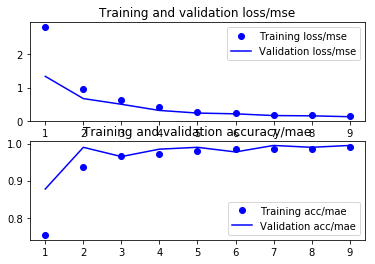

0

In [23]:
mynet.plot_train()

Save (and/or load) final model.

In [ ]:
model.save('net.h5')

In [ ]:
model = load_model('net.h5')

Evaluate the training on testing set (last iteration).

In [24]:
i = 10
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations' + str(i) + '.Epoch3', nr_samples=128, model_name='Marth-3epoch-CEU')
mygene_test = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

mygene_test.majorminor()
mygene_test.filter_freq(0.01)
mygene_test.sort('rows_freq')
mygene_test.sort('cols_freq')
mygene_test.resize((128, 128))
mygene_test.convert()

mygene_test.classes = np.array([0,300])
classes_idx = get_index_classes(mygene_test.targets, mygene_test.classes)
mygene_test.subset(classes_idx)
rnd_idx = get_index_random(mygene_test)
mygene_test.subset(rnd_idx)

mygene_test.targets = to_binary(mygene_test.targets)

In [25]:
mynet.test = model.evaluate(mygene_test.data, mygene_test.targets, batch_size=None, verbose=0)
print(mynet.test)

[0.13000290095806122, 0.995]


Plot confusion matrix (or scatter plot)

In [26]:
mynet.predict(mygene_test, model)
mynet.values.shape

(3, 4000)

0

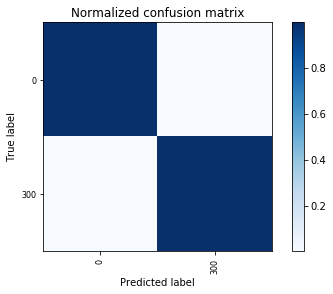

In [27]:
mynet.plot_cm(mygene_test.classes)

0

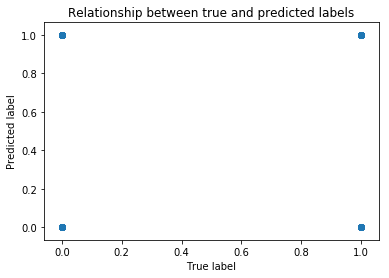

In [28]:
mynet.plot_scatter()